In [1]:
import os
from PIL import Image
import numpy as np

folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\test'
image_size = (16, 16)
image_arrays = []

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"): 
        img_path = os.path.join(folder_path, filename)  
        img = Image.open(img_path) 
        img = img.resize(image_size) 
        img_array = np.array(img) 
        img_array = img_array / 255.0  # Normalize to [0, 1]

        if img_array.ndim == 2:  
            img_array = img_array[..., np.newaxis]  # 

        image_arrays.append(img_array)  

load_data = np.array(image_arrays)

In [2]:
load_data.dtype

dtype('float32')

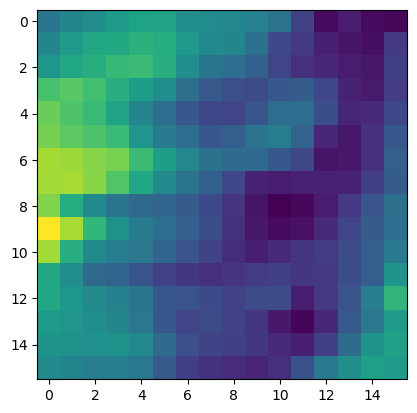

In [3]:
import matplotlib.pyplot as plt
plt.imshow(load_data[3])

In [4]:
load_data.shape

(100, 16, 16, 1)

In [5]:
load_data.dtype

dtype('float32')

In [6]:
from sklearn.model_selection import train_test_split
labels = np.random.randint(0, 16, size=(load_data.shape[0],))
trainX, testX, trainy, testy = train_test_split(load_data,labels, test_size=0.2, random_state=42)

In [7]:
trainX.shape

(80, 16, 16, 1)

In [8]:
def load_real_samples():
    x = trainX.astype('float32')
    x = (x-127.5)/127.5
    return x

In [9]:
dataset = load_real_samples()

In [10]:
def generate_real_samples(dataset,n_samples):
    ix = np.random.randint(0,dataset.shape[0],n_samples)
    x=dataset[ix]
    y=np.ones((n_samples,1))
    return x,y

In [11]:
n_samples = 30
x,y = generate_real_samples(dataset,n_samples)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout,Input
from tensorflow.keras.activations import gelu



def define_discriminator():
    model = Sequential()
    
    
    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=(16, 16, 1)))
    model.add(Activation(gelu))
    
    
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))
    model.add(Activation(gelu))
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    for layer in resnet50.layers:
        layer.trainable = False  
    model.add(resnet50)
    
    model.add(Flatten())
    
    model.add(Dense(1024, activation=gelu))
    model.add(Dropout(0.5))  
    
    model.add(Dense(512, activation=gelu))  
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation=gelu))
    
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)  
    
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model




In [13]:
d_model = define_discriminator()
d_model.summary()

C:\jupyter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 3)           │           1,731 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,344,644 (100.50 MB)

 Trainable params: 2,756,932 (10.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
def define_generator():
    model = Sequential()


    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=(16, 16, 1)))
    model.add(Activation(gelu))
    
    
    
    model.add(Flatten())
    model.add(Dense(256, activation=gelu))
    
   
    model.add(Reshape((16, 16, 1)))
    
    model.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))
    
    
    
    return model

In [15]:
g_model = define_generator()
g_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 1)           │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,195,210 (16.00 MB)

 Trainable params: 4,195,210 (16.00 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import os
from PIL import Image
import numpy as np

folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\train'
image_size = (16, 16)
image_arrays = []

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"): 
        img_path = os.path.join(folder_path, filename)  
        img = Image.open(img_path) 
        img = img.resize(image_size) 
        img_array = np.array(img) 
        img_array = img_array / 255.0  # Normalize to [0, 1]

        if img_array.ndim == 2:  
            img_array = img_array[..., np.newaxis]  # 

        image_arrays.append(img_array)  
modified_data = np.array(image_arrays)

In [17]:
modified_data.dtype

dtype('float32')

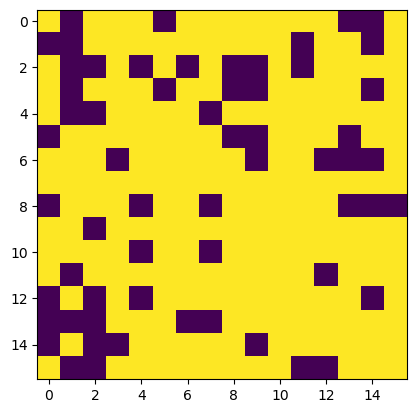

In [18]:
plt.imshow(modified_data[0,:,:,0])

In [19]:
def generate_fake_samples(g_model, modified_data):
    
    x = g_model.predict(modified_data)
    return x


In [20]:
g_model = define_generator()
x = generate_fake_samples(g_model,modified_data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [21]:
x.shape

(80, 16, 16, 1)

In [22]:
x.dtype

dtype('float32')

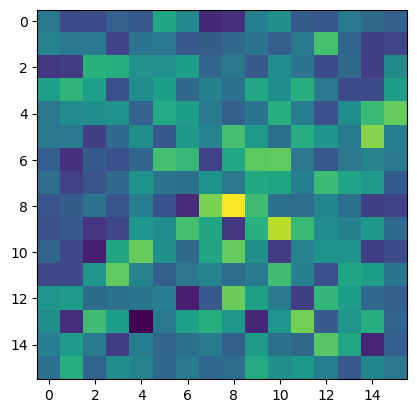

In [23]:
plt.imshow(x[6])

In [24]:
# def generate_fake_samples(g_model, modified_data):
#     x= g_model.predict(modified_data)
#     return x

In [25]:
# x = generate_fake_samples(g_model, modified_data)

In [26]:
def define_gan(g_model,d_model):
    d_model.trainable=False
    model=Sequential()
    model.add(g_model)
    model.add(d_model)
    opt=Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss="binary_crossentropy",optimizer=opt)
    return model

In [27]:
gan_model= define_gan(g_model,d_model)

In [28]:
gan_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 16, 16, 1)           │       4,195,210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │      26,344,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,539,854 (116.50 MB)

 Trainable params: 4,195,210 (16.00 MB)

 Non-trainable params: 26,344,644 (100.50 MB)

In [38]:

def train(g_model, d_model, gan_model, modified_data ,dataset, n_epochs=100, n_batch=4):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = modified_data[:50][:int(n_batch/2)]
    batch = int(n_batch/2)

    for i in range(n_epochs): 
        for j in range(bat_per_epo):
            
            X_real, y_real = generate_real_samples(dataset,batch) 
            d_loss1 = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, half_batch), np.zeros((half_batch.shape[0], 1))
            d_loss2 = d_model.train_on_batch(X_fake, y_fake)
            X_gan, y_gan = generate_fake_samples(g_model, half_batch), np.ones((half_batch.shape[0], 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print(f'd_loss1: {d_loss1}, d_loss2: {d_loss2}, g_loss: {g_loss}')
        
        if (i+1) % 19 == 0:
            summarize_performance(i, g_model, d_model, dataset, modified_data)

In [40]:
# 
# def train(g_model, d_model, gan_model, modified_data ,dataset, n_epochs=2, n_batch=64):
#     bat_per_epo = int(dataset.shape[0] / n_batch)
#     half_batch = modified_data[:50][:int(n_batch/2)]
#     for i in range(n_epochs): 
#         for j in range(bat_per_epo):
            
#             X_real, y_real = generate_real_samples(dataset, half_batch.shape[0] ) #
#             d_loss1 = d_model.train_on_batch(X_real, y_real)
#             X_fake, y_fake = generate_fake_samples(g_model, half_batch), np.zeros((half_batch.shape[0], 1))#half_batch
#             d_loss2 = d_model.train_on_batch(X_fake, y_fake)
#             X_gan, y_gan = generate_fake_samples(g_model, half_batch), np.ones((half_batch.shape[0], 1))
#             g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
#             print(f'd_loss1: {d_loss1}, d_loss2: {d_loss2}, g_loss: {g_loss}')
        
#         if (i+1) % 10 == 0:
#             summarize_performance(i, g_model, d_model, dataset, half_batch.shape[0])

In [42]:
def summarize_performance(epoch, g_model, d_model, dataset,n_samples=4):
    X_real, y_real = generate_real_samples(dataset,n_samples) 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(g_model,n_samples) 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(X_fake,epoch)
    filename = os.path.join(r'C:\Users\OptiSAR\Desktop\gan\save_image', "generate_model_%03d.h5" % (epoch+1))
    g_model.save(filename)

In [44]:
from matplotlib import pyplot
save_dir=r'C:\Users\OptiSAR\Desktop\gan\save image'
def save_plot(examples, epoch, n=7, save_dir=save_dir):
    # Normalize the images
    examples = (examples + 1) / 2.0
    if not os.path.exist(save_dir):
        os.makedirs(save_dir)
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    filename = os.path.join(save_dir, 'generated_plot_e%03d.tif' % (epoch+1))
    pyplot.savefig(filename, format='tif')
    pyplot.close()

In [46]:
train(g_model, d_model, gan_model, dataset, modified_data, n_epochs=20, n_batch=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
d_loss1: [array(1.2726607, dtype=float32), array(0.52380955, dtype=float32)], d_loss2: [array(1.279616, dtype=float32), array(0.5237069, dtype=float32)], g_loss: [array(1.279616, dtype=float32), array(1.279616, dtype=float32), array(0.5237069, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
d_loss1: [array(1.2742046, dtype=float32), array(0.52575105, dtype=float32)], d_loss2: [array(1.2793995, dtype=float32), array(0.52350426, dtype=float32)], g_loss: [array(1.2793995, dtype=float32), array(1.2793995, dtype=float32), array(0.52350426, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
d_loss1: [array(1.274056, dtype=float32), array(0.5255319, dtype=float32)], d_loss2: [array(1.2723632, dtype=float32), array(0.52330506, dtype=float32)], g_loss: [array(1.2723632, dtype=float32), array(1.2723632, dtype=float32), array(0.52330506, 

ValueError: maximum supported dimension for an ndarray is 32, found 80

In [68]:
x1= modified_data[1:2]

In [70]:
im_out = g_model.predict(x1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


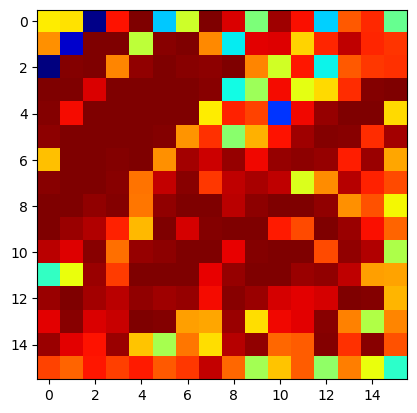

In [72]:
output = plt.imshow(im_out[0,:,:,0], cmap = 'jet')

In [54]:
import tifffile

In [56]:
image_data = im_out[0, :, :, 0] / np.max(im_out[0, :, :, 0])

# Save the image as a .tif file with float32 format
tifffile.imwrite('output_jmage3.tif', image_data.astype(np.float32))